Facial emotion classification is a vital task in computer vision, enabling applications like human-computer interaction and sentiment analysis. In this notebook the task is accomplished with Vision Transformer (ViT). Unlike traditional CNNs, ViT utilizes a transformer architecture, originally designed for natural language processing, offering promising results in image classification tasks. The aim is to train a ViT model on a dataset of facial images annotated with various emotions to accurately predict emotional states, which are angry, disgust, fear, happy, neutral, sad, surprise. Through this notebook, we explore ViT's effectiveness in facial emotion classification, aiming to advance affective computing and human-centered AI applications.

In [ ]:
#!pip install patchify

In [ ]:
!unzip drive/MyDrive/FacialEmotion.v1i.folder.zip

In [17]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


### Import needed libraries

In [55]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd

### Define the architecture of the ViT model and related components

In [40]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        # Initialize weights for the class token
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable=True
        )

    def call(self, inputs):
        # Get batch size and hidden dimension
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        # Broadcast the class token to match the input shape
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls


def mlp(x, cf):
    # Multi-Layer Perceptron (MLP) block
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x


def transformer_encoder(x, cf):
    # Transformer encoder block
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x


def ViT(cf):
    # Vision Transformer (ViT) model
    input_shape = (cf["num_patches"], cf["patch_size"] * cf["patch_size"] * cf["num_channels"])
    inputs = Input(input_shape)  # Define input layer
    patch_embed = Dense(cf["hidden_dim"])(inputs)  # Patch embedding layer

    # Positional embedding
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)
    embed = patch_embed + pos_embed

    # Add class token to the input
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed])

    # Transformer encoder layers
    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    x = LayerNormalization()(x)
    x = x[:, 0, :]  # Take only the first token
    x = Dense(cf["num_classes"], activation="softmax")(x)  # Output layer

    model = Model(inputs, x)  # Define the model
    return model


In [41]:
# Define hyperparameters
config = {}
config["image_size"] = 150
config["num_channels"] = 3
config["patch_size"] = 25
config["num_patches"] = (config["image_size"]**2) // (config["patch_size"]**2)
config["flat_patches_shape"] = (config["num_patches"], config["patch_size"]*config["patch_size"]*config["num_channels"])

config["batch_size"] = 128
config["lr"] = 1e-6
config["num_epochs"] = 150
config["num_classes"] = 7
config["class_names"] = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Function to load and split data
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)

    return train_x, valid_x, test_x

# Function to process image and label
def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (config["image_size"], config["image_size"]))
    image = image/255.0

    patch_shape = (config["patch_size"], config["patch_size"], config["num_channels"])
    patches = patchify(image, patch_shape, config["patch_size"])
    patches = np.reshape(patches, config["flat_patches_shape"])
    patches = patches.astype(np.float32)

    class_name = path.split("/")[-2]
    class_idx = config["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx

# Function to parse data into TensorFlow format
def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, config["num_classes"])

    patches.set_shape(config["flat_patches_shape"])
    labels.set_shape(config["num_classes"])

    return patches, labels

# Function to create TensorFlow dataset
def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


In [42]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Outup Directory
create_dir("files")

# Paths
dataset_path = "train"
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")

### Dataset built and preprocessing.
The utilized dataset can be found at the following id:
https://universe.roboflow.com/project1-zqy9w/facialemotion/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true

In [ ]:
# Dataset
train_x, valid_x, test_x = load_data(dataset_path)
print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

train_ds = tf_dataset(train_x, batch=config["batch_size"])
valid_ds = tf_dataset(valid_x, batch=config["batch_size"])
test_ds = tf_dataset(test_x, batch=config["batch_size"])

##### Let's check the balance of the classes

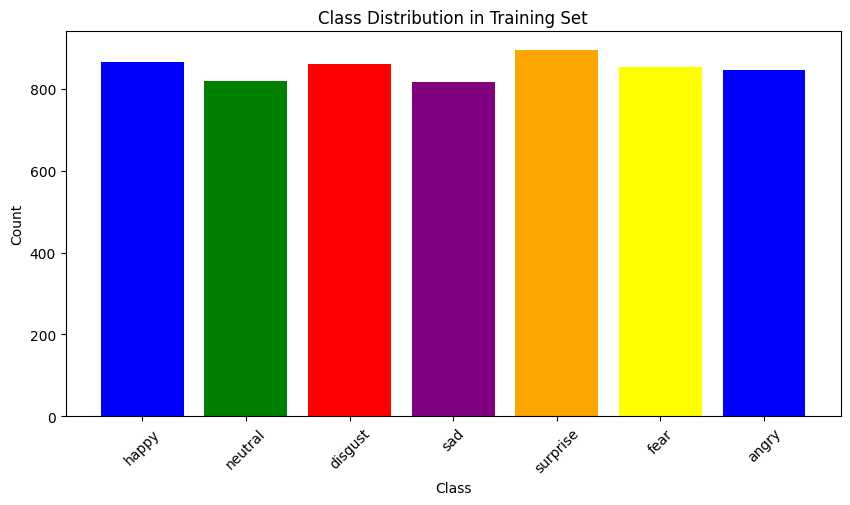

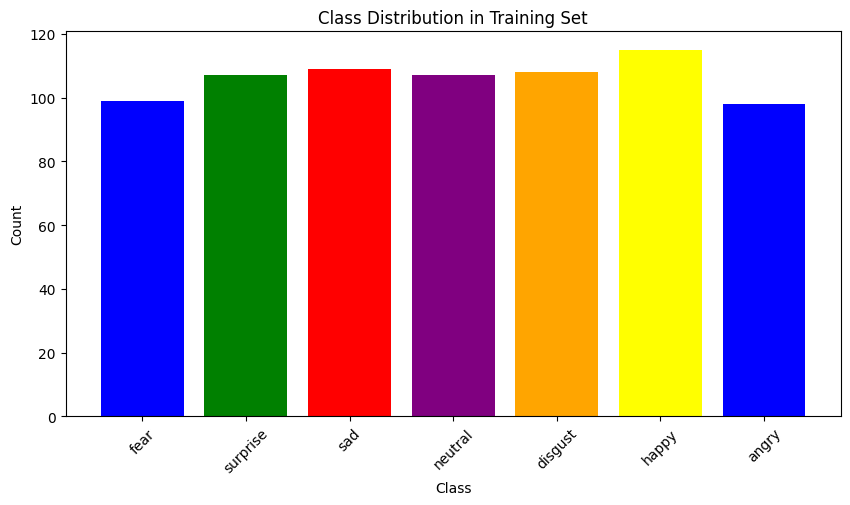

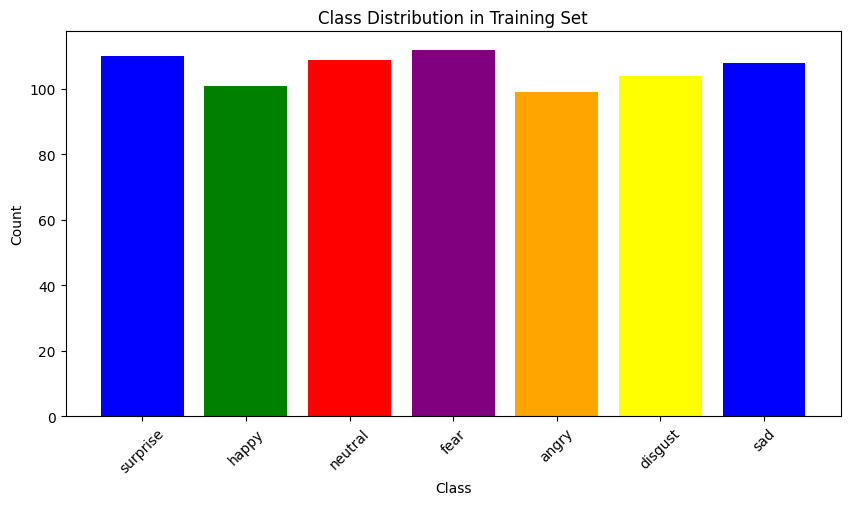

In [54]:
def plot_class_distribution(training_set_paths):
    # Extract class labels from the paths
    classes = [path.split('/')[1] for path in training_set_paths]

    # Count the occurrences of each class
    class_counts = {}
    for cls in classes:
        class_counts[cls] = class_counts.get(cls, 0) + 1

    # Define colors for each class
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']

    # Plot the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color=colors)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in Training Set')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_x)
plot_class_distribution(valid_x)
plot_class_distribution(test_x)

### Train the model

In [ ]:
# Model train
model = ViT(config)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(config["lr"], clipvalue=1.0),
    metrics=["acc"]
)

callbacks = [
    ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
]

model.fit(
    train_ds,
    epochs=config["num_epochs"],
    validation_data=valid_ds,
    callbacks=callbacks
)

##### A visual summary of the model

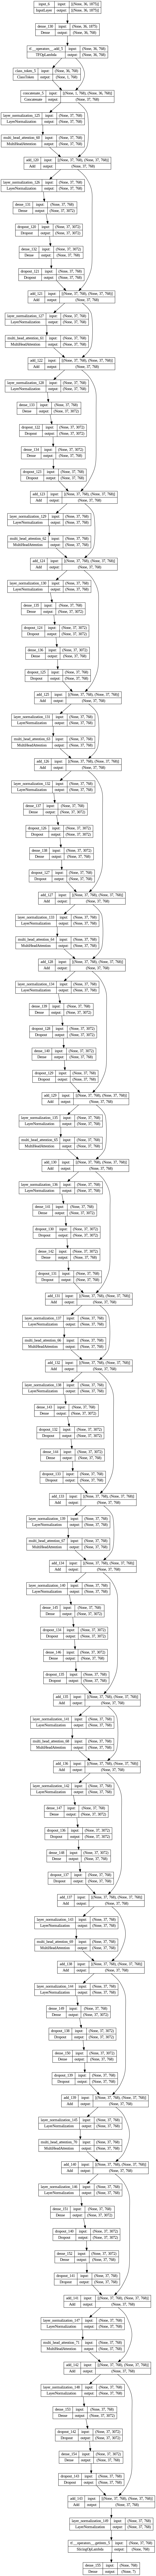

In [30]:
model = ViT(config)
plot_model(model, show_shapes=True)

### Evaluation of the model

In [47]:
# Load the Vision Transformer (ViT) model with specified hyperparameters
model = ViT(config)

# Load pre-trained weights into the model
model.load_weights("drive/MyDrive/model.h5")

# Compile the model with categorical crossentropy loss function,
# Adam optimizer with specified learning rate, and accuracy as the metric
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(config["lr"]),
    metrics=["acc"]
)

# Evaluate the model on the test dataset and retrieve the loss and accuracy
loss, accuracy = model.evaluate(test_ds)

# Print the accuracy obtained from the evaluation
print("Test Accuracy:", accuracy)

6/6 [==============================] - 12s 1s/step - loss: 0.1610 - acc: 0.9502
Test Accuracy: 0.9502018690109253


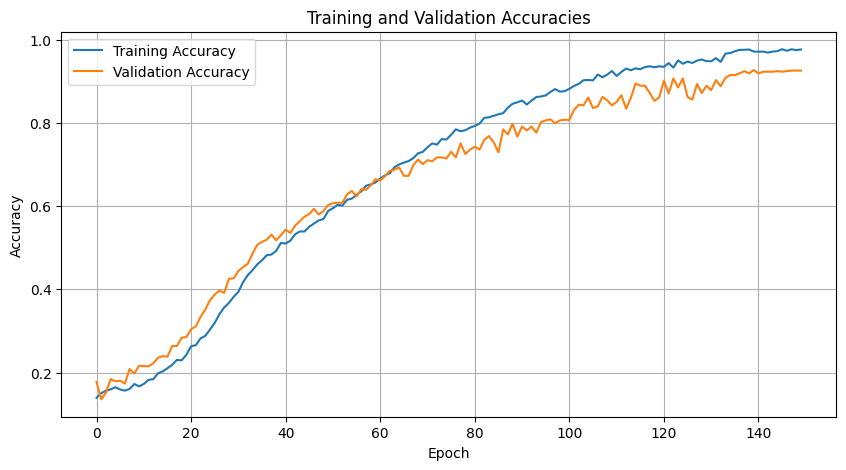

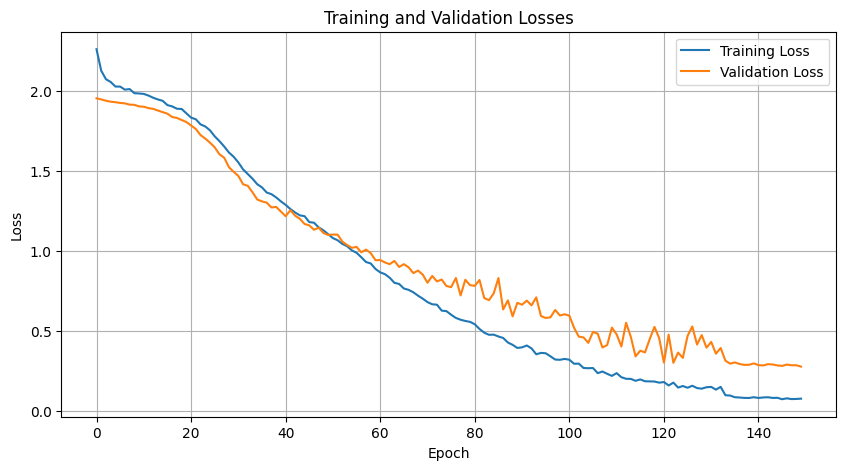

In [49]:
def plot_training_curves(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Extract training and validation accuracies
    epochs = df['epoch']
    acc = df['acc']
    val_acc = df['val_acc']

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss_curves(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Extract training and validation losses
    epochs = df['epoch']
    loss = df['loss']
    val_loss = df['val_loss']

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

csv_file = 'log.csv'
plot_training_curves(csv_file)
plot_loss_curves(csv_file)

Vision Transformer (ViT) for facial emotion classification has demonstrated outstanding performance, achieving an accuracy of 95%. This success underscores ViT's effectiveness in capturing nuanced features from facial images to accurately discern emotional states.